## Haxby data set:
Haxby is a high-quality block-design fMRI dataset from a study on face & object representation in the human ventral temporal cortex (This cortex is involved in the high-level visual processing of complex stimuli). It consists of 6 subjects with 12 runs per subject. In this experiment during each run, the subjects passively viewed greyscale images of 8 object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval.

## Project Goal
For this project i am trying machine learning and deep learning methods to learning about barin decoding and predicting which object category the subject saw by analyzing the fMRI activity recorded masks of the ventral stream.

In [1]:
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

from nilearn.plotting import plot_anat, show, plot_stat_map, plot_matrix
from nilearn import datasets, plotting, image
from nilearn.image import mean_img, get_data 
from nilearn.input_data import NiftiMasker
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier,  RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [2]:
%matplotlib inline
#%load_ext memory_profiler

## Dataset

In [3]:
# If we don't define which subject by default 2nd subject will be fetched.
haxby_ds = datasets.fetch_haxby(fetch_stimuli=True)
# print(haxby_ds)

# To define which subject to be fetched:
# haxby_ds = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)

len(haxby_ds.func)

1

In [4]:
# Look inside the data
haxby_ds.keys()

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description', 'stimuli'])

In [5]:
mask_file = haxby_ds.mask
labels = haxby_ds.session_target[0]
mask_vt_file = haxby_ds.mask_vt[0]
mask_face_file = haxby_ds.mask_face[0]

# 'func' is a list of filenames: one for each subject
func_file = haxby_ds.func[0]

# Load the behavioral data that we will predict
beh_label = pd.read_csv(haxby_ds.session_target[0], sep=" ")

# Extract tags indicating to which acquisition run a tag belongs
session = beh_label['chunks']

# Preparing the data (Load target information as string and give a numerical identifier to each)
y = beh_label['labels']

# Identify the resting state
nonrest_task_mask = (y != 'rest')

# Remove the resting state and find names of remaining active labels
categories = y[nonrest_task_mask].unique()
#session = session[nonrest_task_mask]

# Get the labels of the numerical conditions represented by the vector y
unique_conditions, order = np.unique(categories, return_index=True)

# Sort the conditions by the order of appearance
unique_conditions = unique_conditions[np.argsort(order)]

# Extract tags indicating to which acquisition run a tag belongs
session_labels = beh_label['chunks'][nonrest_task_mask]

In [6]:
# Print basic information on the dataset
print('Functional nifti images are located at: %s' % haxby_ds.func[0])
print('Mask nifti image (3D) is located at:  %s' % haxby_ds.mask)
print('First subject functional nifti images (4D) are at: %s' %func_file)  # 4D data

Functional nifti images are located at: /home/srastegarnia/nilearn_data/haxby2001/subj2/bold.nii.gz
Mask nifti image (3D) is located at:  /home/srastegarnia/nilearn_data/haxby2001/mask.nii.gz
First subject functional nifti images (4D) are at: /home/srastegarnia/nilearn_data/haxby2001/subj2/bold.nii.gz


In [7]:
# Checkout the confounds of the data
session_target = pd.read_csv(haxby_ds['session_target'][0], sep='\t')

session_target.head()

,labels chunks
0,rest 0
1,rest 0
2,rest 0
3,rest 0
4,rest 0


## Preparing the fMRI data (smooth and apply the mask)

In [8]:
# For decoding, standardizing is important, we are also smoothing the data

nifti_masker = NiftiMasker(mask_img=mask_file, standardize=True, sessions=session,  smoothing_fwhm=4,
                           memory="nilearn_cache", memory_level=1)

X = nifti_masker.fit_transform(func_file)


# Remove the resting state
#X = X[nonrest_task_mask]


## Plot Haxby masks

In [9]:
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)
fmri_masked = masker.fit_transform(func_file)

# Report depict the computed mask
masker.generate_report()

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,/home/srastegarnia/nilearn_data/haxby2001/subj2/mask4_vt.nii.gz
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


In [10]:
# The variable “fmri_masked” is a numpy array
print(fmri_masked)

[[ 7.6757896e-01  2.3108697e+00 -2.0519443e-01 ... -1.0261143e+00
   8.7993503e-02  2.0720518e+00]
 [ 5.5640817e-01  1.6833434e+00 -2.4644937e-01 ... -7.0238107e-01
  -3.4570047e-01  2.0341001e+00]
 [ 7.6757896e-01  1.9186659e+00  1.0802225e-03 ... -9.9374104e-01
  -2.7630943e-01  2.1479552e+00]
 ...
 [-4.2905563e-01 -1.6896105e+00 -7.4150854e-01 ... -1.5440876e+00
   1.8054217e+00 -1.6709718e-01]
 [-1.4749455e-01 -1.8072717e+00 -2.4644937e-01 ... -1.7707009e+00
   1.5452052e+00  7.8169477e-01]
 [-2.1788482e-01 -1.4542881e+00  1.0802225e-03 ... -1.6412076e+00
   1.2676411e+00  8.9554977e-01]]


In [11]:
print(fmri_masked.shape)

(1452, 464)


## Converting the Mask to a Matrix

In [12]:
# load bold image into memory as a nibabel image
func = nib.load(func_file)

# load mask image into memory as a nibabel image
mask = nib.load(mask_file) 

# get the physical data of the mask (3D matrix of voxels)
mask_data = mask.get_data() 

print(func.shape)
print(mask.shape) 
print(len(mask_data[mask_data==1]))

(40, 64, 64, 1452)
(40, 64, 64)
39912


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [13]:
# Create the masker object 
masker = NiftiMasker(mask_img=mask_file, standardize=True)

# Create a numpy matrix from the BOLD data, using the mask for the transformation
#%memit bold_masked = masker.fit_transform(bold_path)
func_masked = masker.fit_transform(func_file)

# View the dimensions of the matrix. The shape represents the number of time-stamps by the number of voxels in the mask. 
print(func_masked.shape)

(1452, 39912)


In [14]:
# Viewing the numerical values of the matrix
print(func_masked)

[[ 1.2909995   1.6757168   1.2242533  ... -1.1886454  -1.1722565
  -1.2179288 ]
 [ 1.2238345   1.5655576   0.78668636 ... -1.1886454  -1.1722565
  -1.2179288 ]
 [ 1.1118928   1.5655576   1.0540884  ... -1.1886454  -1.1722565
  -1.2179288 ]
 ...
 [-0.83589315 -0.83040446 -0.81772596 ...  0.7241257   0.9135108
   0.8171516 ]
 [-0.83589315 -0.83040446 -0.81772596 ...  1.185829    1.4349526
   0.9215147 ]
 [-0.83589315 -0.83040446 -0.81772596 ...  1.1198715   1.239412
   0.76497006]]


In [15]:
# Load the labels from a csv into an array using pandas
stimuli = pd.read_csv(labels, sep=' ')

In [16]:
# View the dimensions of the matrix
print(stimuli.shape)

# Viewing the values of the matrix
print(stimuli)

(1452, 2)
     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


In [17]:
targets = stimuli['labels']
print(targets)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


In [18]:
targets_mask = targets.isin(['face', 'cat'])
print(targets_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1447    False
1448    False
1449    False
1450    False
1451    False
Name: labels, Length: 1452, dtype: bool


In [19]:
func_masked = func_masked[targets_mask]
func_masked.shape

(216, 39912)

In [20]:
targets_masked = targets[targets_mask]

print(targets_masked.shape)
print(targets_masked)

(216,)
21      face
22      face
23      face
24      face
25      face
        ... 
1427     cat
1428     cat
1429     cat
1430     cat
1431     cat
Name: labels, Length: 216, dtype: object


## Decoding with ANOVA + SVM: face vs house in the Haxby dataset

In [21]:
# Restrict the analysis to faces and places
condition_mask = beh_label['labels'].isin(['face', 'house'])
conditions_f_h = y[condition_mask]

# Confirm that we now have 2 conditions
print(conditions_f_h.unique())

# Record these as an array of sessions, with fields
# for condition (face or house) and run
session_f_h = beh_label[condition_mask].to_records(index=False)
print(session_f_h.dtype.names)

['face' 'house']
('labels', 'chunks')


In [22]:
# Apply our condition_mask to fMRI data
X_f_h = X[condition_mask]

In [23]:
#Build the decoder

#Define the prediction function to be used. Here we use a Support Vector Classification, with a linear kernel
svc = SVC(kernel='linear')

# Define the dimension reduction to be used. (keep 5% of voxels)
feature_selection = SelectPercentile(f_classif, percentile=5)

# We have SVC classifier and our feature selection (SelectPercentile),then plug them together in a *pipeline*:
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [24]:
# Fit the decoder and predict
anova_svc.fit(X_f_h, conditions_f_h)
y_pred = anova_svc.predict(X_f_h)

In [25]:
# Obtain prediction scores via cross validation

# Define the cross-validation scheme used for validation, using LeaveOneGroupOut cross-validation.
cv = LeaveOneGroupOut()

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = cross_val_score(anova_svc, X_f_h, conditions_f_h, cv=cv, groups=session_f_h)

# Return the corresponding mean prediction accuracy
classification_accuracy = cv_scores.mean()

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" % (classification_accuracy, 1. / len(conditions_f_h.unique())))

Classification accuracy: 0.9537 / Chance level: 0.500000


Visualizing the results:

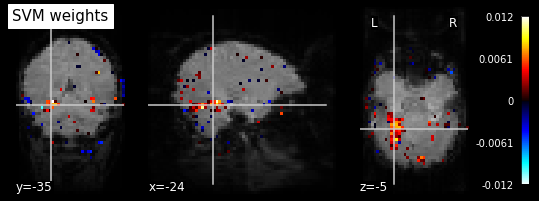

In [26]:
# Look at the SVC’s discriminating weights
coef = svc.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse masking
weight_img = masker.inverse_transform(coef)

# Use the mean image as a background to avoid relying on anatomical data
mean_img = image.mean_img(func_file)

# Create the figure
plot_stat_map(weight_img, mean_img, title='SVM weights')

# Save the results as a Nifti file
#weight_img.to_file('haxby_face_vs_house.nii')

## ROI-based decoding analysis
In this section, I am looking at decoding accuracy for different objects in three different masks: the full ventral stream (mask_vt), the house selective areas (mask_house), and the face-selective areas (mask_face), that have been defined via a standard GLM-based analysis.

In [27]:
# extract tags indicating to which acquisition run a tag belongs
session_labels = beh_label["chunks"][nonrest_task_mask]

In [28]:
# The classifier: a support vector classifier
classifier = SVC(C=1., kernel="linear")

# A classifier to set the chance level
dummy_classifier = DummyClassifier()

# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

mask_names = ['mask_vt', 'mask_face', 'mask_house']

mask_scores = {}
mask_chance_scores = {}

for mask_name in mask_names:
    print("Working on mask %s" % mask_name)
    
    # Standardizing
    mask_filename = haxby_ds[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    masked_timecourses = masker.fit_transform(func_file)[nonrest_task_mask]

    mask_scores[mask_name] = {}
    mask_chance_scores[mask_name] = {}

    for category in categories:
        print("Processing %s %s" % (mask_name, category))
        classification_target = (y[nonrest_task_mask] == category)
        mask_scores[mask_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="roc_auc",
        )

        mask_chance_scores[mask_name][category] = cross_val_score(
            dummy_classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="roc_auc",
        )

        print("Scores: %1.2f +- %1.2f" % (
            mask_scores[mask_name][category].mean(),
            mask_scores[mask_name][category].std()))

Working on mask mask_vt
Processing mask_vt scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.90 +- 0.08
Processing mask_vt face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.97 +- 0.03
Processing mask_vt cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.96 +- 0.03
Processing mask_vt shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.94 +- 0.07
Processing mask_vt house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 1.00 +- 0.00
Processing mask_vt scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 1.00 +- 0.00
Processing mask_vt bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.90 +- 0.07
Processing mask_vt chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.94 +- 0.03
Working on mask mask_face
Processing mask_face scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.64 +- 0.16
Processing mask_face face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.88 +- 0.07
Processing mask_face cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.65 +- 0.16
Processing mask_face shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.62 +- 0.15
Processing mask_face house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.67 +- 0.16
Processing mask_face scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.86 +- 0.12
Processing mask_face bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.46 +- 0.19
Processing mask_face chair


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.57 +- 0.14
Working on mask mask_house
Processing mask_house scissors


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.82 +- 0.10
Processing mask_house face


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.84 +- 0.09
Processing mask_house cat


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.80 +- 0.10
Processing mask_house shoe


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.81 +- 0.13
Processing mask_house house


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.99 +- 0.02
Processing mask_house scrambledpix


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.91 +- 0.11
Processing mask_house bottle


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

Scores: 0.82 +- 0.13
Processing mask_house chair
Scores: 0.88 +- 0.09


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of stra

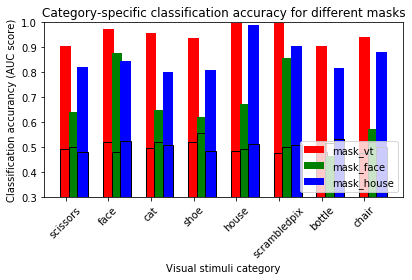

In [29]:
# Visualizing the results as a bar plot
plt.figure()

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, mask_name in zip('rgb', mask_names):
    score_means = [mask_scores[mask_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=mask_name,
            width=.25, color=color)

    score_chance = [mask_chance_scores[mask_name][category].mean()
                    for category in categories]
    plt.bar(tick_position, score_chance,
            width=.25, edgecolor='k', facecolor='none')

    tick_position = tick_position + .2

plt.ylabel('Classification accurancy (AUC score)')
plt.xlabel('Visual stimuli category')
plt.ylim(0.3, 1)
plt.legend(loc='lower right')
plt.title('Category-specific classification accuracy for different masks')
plt.tight_layout()

## Different multi-class strategies
We compare one vs all and one vs one multi-class strategies: the overall cross-validated accuracy and the confusion matrix.

In [30]:
# Build the decoders, using scikit-learn

svc_ovo = OneVsOneClassifier(Pipeline([
    ('anova', SelectKBest(f_classif, k=500)),
    ('svc', SVC(kernel='linear'))
]))

svc_ova = OneVsRestClassifier(Pipeline([
    ('anova', SelectKBest(f_classif, k=500)),
    ('svc', SVC(kernel='linear'))
]))

In [31]:
# Remove the "rest" condition
y = y[nonrest_task_mask]
X = X[nonrest_task_mask]

cv_scores_ovo = cross_val_score(svc_ovo, X, y, cv=5, verbose=1)

cv_scores_ova = cross_val_score(svc_ova, X, y, cv=5, verbose=1)

print('OvO:', cv_scores_ovo.mean())
print('OvA:', cv_scores_ova.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


OvO: 0.601855088049469
OvA: 0.6712058072321548


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.1s finished


Text(0.5, 1.0, 'Prediction: accuracy score')

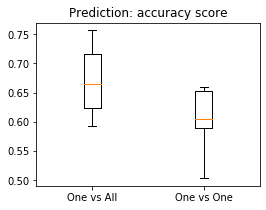

In [32]:
# Plot barplots of the prediction scores

plt.figure(figsize=(4, 3))
plt.boxplot([cv_scores_ova, cv_scores_ovo])
plt.xticks([1, 2], ['One vs All', 'One vs One'])
plt.title('Prediction: accuracy score')

Plot a confusion matrix:

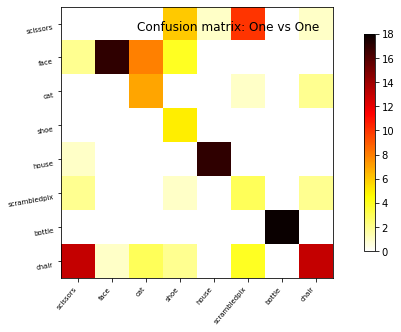

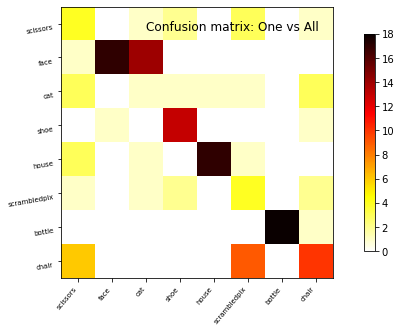

In [33]:
# We fit on the the first 10 sessions and plot a confusion matrix on the last 2 sessions

svc_ovo.fit(X[session_labels < 10], y[session_labels < 10])
y_pred_ovo = svc_ovo.predict(X[session_labels >= 10])

plot_matrix(confusion_matrix(y_pred_ovo, y[session_labels >= 10]),
            labels=unique_conditions,
            title='Confusion matrix: One vs One', cmap='hot_r')

svc_ova.fit(X[session_labels < 10], y[session_labels < 10])
y_pred_ova = svc_ova.predict(X[session_labels >= 10])

plot_matrix(confusion_matrix(y_pred_ova, y[session_labels >= 10]),
            labels=unique_conditions,
            title='Confusion matrix: One vs All', cmap='hot_r')

## Different classifiers for decoding
In this section I am willing to compare the different classifiers on a visual object recognition decoding task.

In [34]:
# Standardizing
masker = NiftiMasker(mask_img=mask_vt_file, standardize=True)
masked_timecourses = masker.fit_transform(func_file)[nonrest_task_mask]

In [35]:
# Support vector classifier
svm = SVC(C=1., kernel="linear")

# The logistic regression
logistic = LogisticRegression(C=1., penalty="l1", solver='liblinear')
logistic_50 = LogisticRegression(C=50., penalty="l1", solver='liblinear')
logistic_l2 = LogisticRegression(C=1., penalty="l2", solver='liblinear')

# Cross-validated versions of these classifiers
# GridSearchCV is slow, but note that it takes an 'n_jobs' parameter that
# can significantly speed up the fitting process on computers with
# multiple cores
svm_cv = GridSearchCV(SVC(C=1., kernel="linear"),
                      param_grid={'C': [.1, 1., 10., 100.]},
                      scoring='f1', n_jobs=1, cv=3, iid=False)

logistic_cv = GridSearchCV(
        LogisticRegression(C=1., penalty="l1", solver='liblinear'),
        param_grid={'C': [.1, 1., 10., 100.]},
        scoring='f1', cv=3, iid=False,
        )
logistic_l2_cv = GridSearchCV(
        LogisticRegression(C=1., penalty="l2", solver='liblinear'),
        param_grid={
            'C': [.1, 1., 10., 100.]
            },
        scoring='f1', cv=3, iid=False,
        )

# The ridge classifier has a specific 'CV' object that can set it's parameters faster than using a GridSearchCV
ridge = RidgeClassifier()
ridge_cv = RidgeClassifierCV()

# A dictionary, to hold all our classifiers
classifiers = {'SVC': svm,
               'SVC cv': svm_cv,
               'log l1': logistic,
               'log l1 50': logistic_50,
               'log l1 cv': logistic_cv,
               'log l2': logistic_l2,
               'log l2 cv': logistic_l2_cv,
               'ridge': ridge,
               'ridge cv': ridge_cv
               }

Prediction scores:

In [36]:
# Run time for all these classifiers

# Make a data splitting object for cross validation
cv = LeaveOneGroupOut()

classifiers_scores = {}

for classifier_name, classifier in sorted(classifiers.items()):
    classifiers_scores[classifier_name] = {}
    print(70 * '_')

    for category in categories:
        classification_target = y[nonrest_task_mask].isin([category])
        t0 = time.time()
        classifiers_scores[classifier_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="f1",
        )

        print(
            "%10s: %14s -- scores: %1.2f +- %1.2f, time %.2fs" %
            (
                classifier_name,
                category,
                classifiers_scores[classifier_name][category].mean(),
                classifiers_scores[classifier_name][category].std(),
                time.time() - t0,
            ),
        )

______________________________________________________________________
       SVC:       scissors -- scores: 0.41 +- 0.31, time 2.23s
       SVC:           face -- scores: 0.58 +- 0.24, time 1.73s
       SVC:            cat -- scores: 0.60 +- 0.25, time 2.09s
       SVC:           shoe -- scores: 0.56 +- 0.23, time 1.89s
       SVC:          house -- scores: 0.81 +- 0.28, time 1.76s
       SVC:   scrambledpix -- scores: 0.79 +- 0.17, time 1.53s
       SVC:         bottle -- scores: 0.53 +- 0.21, time 2.04s
       SVC:          chair -- scores: 0.42 +- 0.25, time 1.85s
______________________________________________________________________


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:       scissors -- scores: 0.41 +- 0.31, time 16.73s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:           face -- scores: 0.58 +- 0.24, time 12.86s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:            cat -- scores: 0.60 +- 0.25, time 15.69s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:           shoe -- scores: 0.56 +- 0.23, time 16.06s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:          house -- scores: 0.81 +- 0.28, time 9.83s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:   scrambledpix -- scores: 0.79 +- 0.17, time 12.38s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:         bottle -- scores: 0.53 +- 0.21, time 16.77s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

    SVC cv:          chair -- scores: 0.42 +- 0.25, time 16.01s
______________________________________________________________________
    log l1:       scissors -- scores: 0.43 +- 0.28, time 1.23s
    log l1:           face -- scores: 0.74 +- 0.13, time 0.68s
    log l1:            cat -- scores: 0.63 +- 0.23, time 1.03s
    log l1:           shoe -- scores: 0.49 +- 0.19, time 1.07s
    log l1:          house -- scores: 0.89 +- 0.13, time 0.50s
    log l1:   scrambledpix -- scores: 0.70 +- 0.18, time 0.61s
    log l1:         bottle -- scores: 0.47 +- 0.15, time 1.56s
    log l1:          chair -- scores: 0.44 +- 0.14, time 1.08s
______________________________________________________________________
 log l1 50:       scissors -- scores: 0.44 +- 0.24, time 1.80s
 log l1 50:           face -- scores: 0.68 +- 0.14, time 0.88s
 log l1 50:            cat -- scores: 0.66 +- 0.18, time 2.04s
 log l1 50:           shoe -- scores: 0.48 +- 0.19, time 1.99s
 log l1 50:          house -- scores: 

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:       scissors -- scores: 0.38 +- 0.28, time 8.31s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:           face -- scores: 0.70 +- 0.18, time 5.83s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:            cat -- scores: 0.52 +- 0.28, time 7.05s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:           shoe -- scores: 0.49 +- 0.19, time 8.06s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:          house -- scores: 0.84 +- 0.19, time 4.59s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:   scrambledpix -- scores: 0.69 +- 0.14, time 4.85s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:         bottle -- scores: 0.40 +- 0.25, time 7.87s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l1 cv:          chair -- scores: 0.44 +- 0.14, time 7.49s
______________________________________________________________________
    log l2:       scissors -- scores: 0.51 +- 0.15, time 1.74s
    log l2:           face -- scores: 0.55 +- 0.19, time 1.56s
    log l2:            cat -- scores: 0.54 +- 0.20, time 1.68s
    log l2:           shoe -- scores: 0.51 +- 0.17, time 1.62s
    log l2:          house -- scores: 0.63 +- 0.22, time 1.43s
    log l2:   scrambledpix -- scores: 0.78 +- 0.18, time 1.44s
    log l2:         bottle -- scores: 0.43 +- 0.20, time 1.62s
    log l2:          chair -- scores: 0.54 +- 0.17, time 1.65s
______________________________________________________________________


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:       scissors -- scores: 0.50 +- 0.15, time 13.10s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:           face -- scores: 0.56 +- 0.20, time 11.94s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:            cat -- scores: 0.55 +- 0.20, time 12.49s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:           shoe -- scores: 0.51 +- 0.17, time 12.45s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:          house -- scores: 0.64 +- 0.22, time 11.29s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:   scrambledpix -- scores: 0.76 +- 0.18, time 11.22s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:         bottle -- scores: 0.44 +- 0.21, time 12.88s


/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The par

 log l2 cv:          chair -- scores: 0.53 +- 0.17, time 12.96s
______________________________________________________________________
     ridge:       scissors -- scores: 0.52 +- 0.22, time 0.31s
     ridge:           face -- scores: 0.62 +- 0.18, time 0.11s
     ridge:            cat -- scores: 0.43 +- 0.18, time 0.12s
     ridge:           shoe -- scores: 0.48 +- 0.21, time 0.12s
     ridge:          house -- scores: 0.90 +- 0.09, time 0.12s
     ridge:   scrambledpix -- scores: 0.79 +- 0.17, time 0.11s
     ridge:         bottle -- scores: 0.41 +- 0.19, time 0.12s
     ridge:          chair -- scores: 0.50 +- 0.21, time 0.14s
______________________________________________________________________
  ridge cv:       scissors -- scores: 0.56 +- 0.26, time 1.22s
  ridge cv:           face -- scores: 0.70 +- 0.13, time 1.15s
  ridge cv:            cat -- scores: 0.54 +- 0.22, time 0.95s
  ridge cv:           shoe -- scores: 0.49 +- 0.18, time 0.94s
  ridge cv:          house -- scores: 

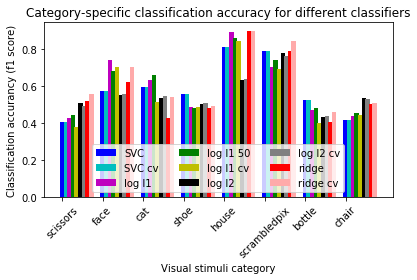

In [37]:
# Make a rudimentary diagram

plt.figure()

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, classifier_name in zip(
        ['b', 'c', 'm', 'g', 'y', 'k', '.5', 'r', '#ffaaaa'],
        sorted(classifiers)):
    score_means = [classifiers_scores[classifier_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=classifier_name, width=.11, color=color)
    tick_position = tick_position + .09

plt.ylabel('Classification accurancy (f1 score)')
plt.xlabel('Visual stimuli category')
plt.ylim(ymin=0)
plt.legend(loc='lower center', ncol=3)
plt.title('Category-specific classification accuracy for different classifiers')
plt.tight_layout()

/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/home/srastegarnia/miniconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can b

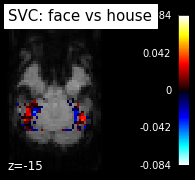

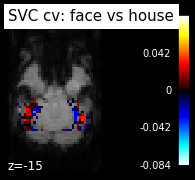

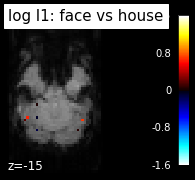

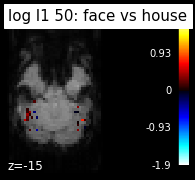

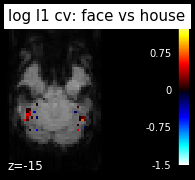

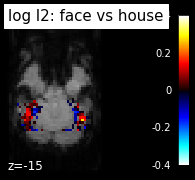

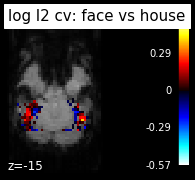

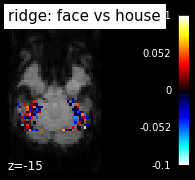

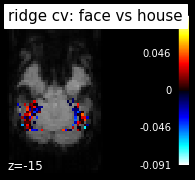

In [38]:
# Plot the face vs house map for the different classifiers

mean_epi_img = image.mean_img(func_file)

# Restrict the decoding to face vs house
condition_mask = y.isin(['face', 'house'])
masked_timecourses = masked_timecourses[
    condition_mask[nonrest_task_mask]]
y_f = (y[condition_mask] == 'face')
# Transform the stimuli to binary values
y_f.astype(np.int)

for classifier_name, classifier in sorted(classifiers.items()):
    classifier.fit(masked_timecourses, y_f)

    if hasattr(classifier, 'coef_'):
        weights = classifier.coef_[0]
    elif hasattr(classifier, 'best_estimator_'):
        weights = classifier.best_estimator_.coef_[0]
    else:
        continue
    weight_img = masker.inverse_transform(weights)
    weight_map = get_data(weight_img)
    threshold = np.max(np.abs(weight_map)) * 1e-3
    plot_stat_map(weight_img, bg_img=mean_epi_img, display_mode='z', cut_coords=[-15],
                  threshold=threshold, title='%s: face vs house' % classifier_name)

# ML Models

### k-Nearest Neighbours

In [39]:
# Shuffling
X_train, X_test, y_train, y_test=train_test_split(func_masked, targets_masked, test_size=0.1, random_state=42, shuffle=True)

In [40]:
# Creating and fitting the nearest-neighbor classifier
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [41]:
y_pred = knn.predict(X_test)

scores = accuracy_score(y_test, y_pred)
print(scores)

0.9090909090909091


### Logistic Regression

In [42]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

scores = accuracy_score(y_test, y_pred)
print(scores)

1.0


### Support Vector Machines

In [43]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

scores = accuracy_score(y_test, y_pred)
print(scores)

0.8181818181818182


### Neural Networks

In [44]:
nn = MLPClassifier(hidden_layer_sizes=(100, 3))
nn.fit(X_train, y_train)

y_pred = nn.predict(X_test)

scores = accuracy_score(y_test, y_pred)
print(scores)

0.8636363636363636


### Links to the turials:

Plotting the used stimuli Haxby dataset: #https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_stimuli.html#sphx-glr-auto-examples-02-decoding-plot-haxby-stimuli-py

Plot Haxby masks: https://nilearn.github.io/auto_examples/01_plotting/plot_haxby_masks.html#sphx-glr-auto-examples-01-plotting-plot-haxby-masks-py

Decoding with ANOVA + SVM: https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_anova_svm.html#sphx-glr-auto-examples-02-decoding-plot-haxby-anova-svm-py

ROI-based decoding analysis: https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_full_analysis.html#roi-based-decoding-analysis-in-haxby-et-al-dataset

Different multi-class strategies: https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_multiclass.html#sphx-glr-auto-examples-02-decoding-plot-haxby-multiclass-py

Different classifiers for decoding: https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_different_estimators.html#sphx-glr-auto-examples-02-decoding-plot-haxby-different-estimators-py

Preparing the data: https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html

k-Nearest Neighbours:

train_test_split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

KNeighborsClassifier(): https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

accuracy_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Support Vector Machine: 
https://scikit-learn.org/stable/modules/svm.html 

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

Neural Network:
https://scikit-learn.org/stable/modules/neural_networks_supervised.html 
MLPClassifier: 
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier